In [1]:
import pandas as pd
import os
import PIL
from PIL import Image
import matplotlib.image as image
from sklearn import preprocessing
import tensorflow as tf
import pathlib

In [2]:
dataset_url = "images"

In [3]:
data_dir = "images"
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

58954


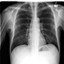

In [5]:
cxr = list(data_dir.glob('CXR/*'))
PIL.Image.open(str(cxr[0]))

In [6]:
batch_size = 32
IMG_SIZE = (64, 64)

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 58954 files belonging to 6 classes.
Using 47164 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 58954 files belonging to 6 classes.
Using 11790 files for validation.


In [9]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

In [10]:
class_names = train_ds.class_names
print(class_names)

['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


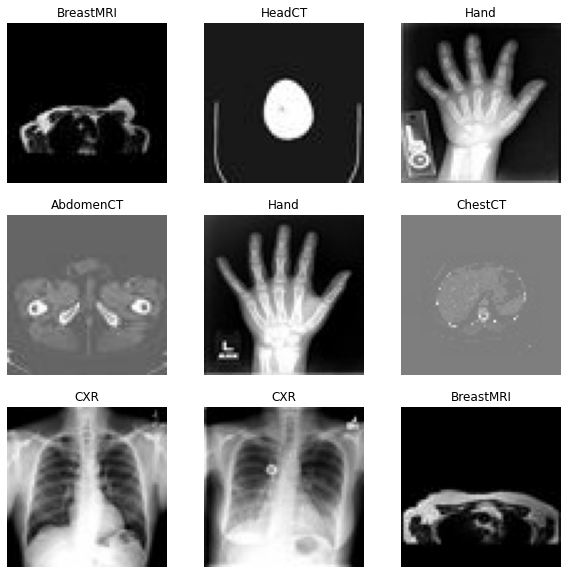

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

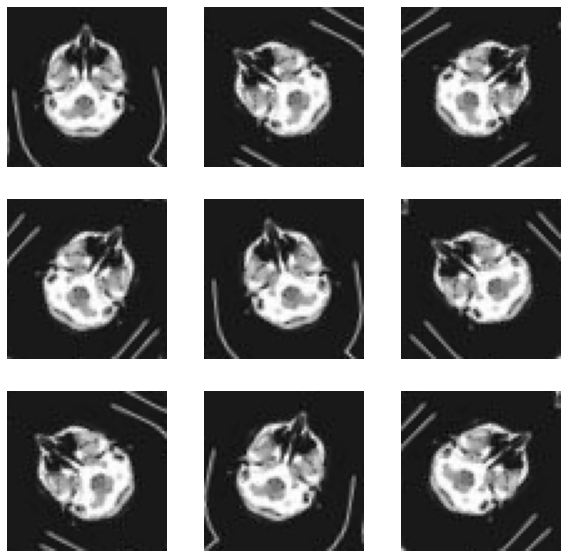

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [15]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [16]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [19]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling=None,
    classifier_activation="softmax",
)

In [20]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 2, 2, 512)


In [21]:
base_model.trainable = False

In [22]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [23]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [24]:
prediction_layer = tf.keras.layers.Dense(7, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 7)


In [25]:
inputs = tf.keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)

x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 64, 64, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 64, 64, 3)        0         
                                                                 
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [28]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

369/369 [==============================] - 161s 434ms/step - loss: 10.5170 - accuracy: 0.0862


In [29]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 10.52
initial accuracy: 0.09


In [30]:
model.trainable=True

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 64, 64, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 64, 64, 3)        0         
                                                                 
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [32]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset
                    )

Epoch 1/10
1474/1474 [==============================] - 836s 567ms/step - loss: 0.1944 - accuracy: 0.9694 - val_loss: 0.0094 - val_accuracy: 0.9969
Epoch 2/10
1474/1474 [==============================] - 772s 524ms/step - loss: 0.0151 - accuracy: 0.9967 - val_loss: 0.0031 - val_accuracy: 0.9989
Epoch 3/10
1474/1474 [==============================] - 1718s 1s/step - loss: 0.0095 - accuracy: 0.9979 - val_loss: 0.0025 - val_accuracy: 0.9992
Epoch 4/10
1474/1474 [==============================] - 780s 529ms/step - loss: 0.0104 - accuracy: 0.9978 - val_loss: 0.0052 - val_accuracy: 0.9982
Epoch 5/10
1474/1474 [==============================] - 798s 541ms/step - loss: 0.0098 - accuracy: 0.9983 - val_loss: 0.0081 - val_accuracy: 0.9979
Epoch 6/10
1474/1474 [==============================] - 819s 556ms/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 4.3631e-04 - val_accuracy: 0.9998
Epoch 7/10
1474/1474 [==============================] - 828s 562ms/step - loss: 0.0087 - accuracy: 0.9985 - va

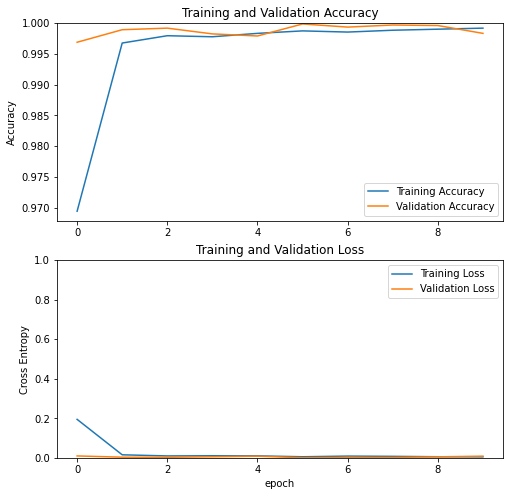

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

73/73 [==============================] - 27s 373ms/step - loss: 0.0156 - accuracy: 0.9983
Test accuracy : 0.9982876777648926


In [35]:
model.save('modelvgg.h5', include_optimizer=False)

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
Labels:
 [0 1 2 0 5 5 0 3 0 1 4 4 3 0 2 4 4 2 0 4 0 0 5 5 1 4 0 1 3 3 0 3]


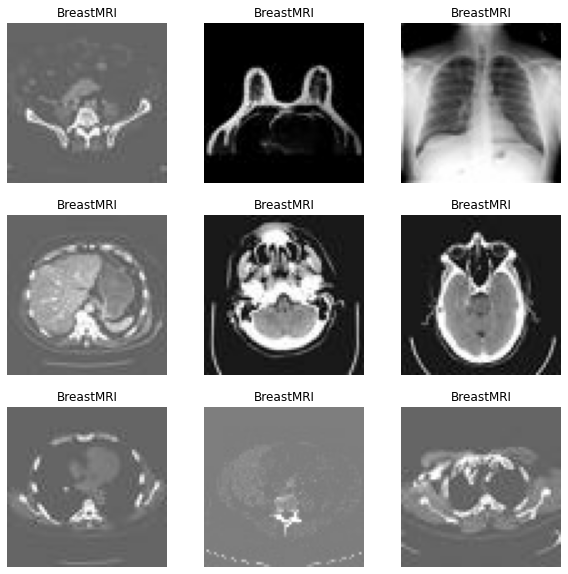

In [36]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [37]:
new_model = tf.keras.models.load_model('modelvgg.h5')

# Check its architecture
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 64, 64, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 64, 64, 3)        0         
                                                                 
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      